In [2]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lib.taa_tools as taa

np.set_printoptions(threshold=10000,suppress=True) 
filterwarnings('ignore')

In [185]:
CREDIT_SCORE = "../data/credit_scoring.csv"
CREDIT_SCORE_HET = "../data/credit.data"
SPAM = "../data/SMSSpamCollection.data"
YELP = "../data/yelp-text-by-stars.csv"

# Apprentissage supervisé : Feature engineering et Classification

## Chargement des données et préparation :

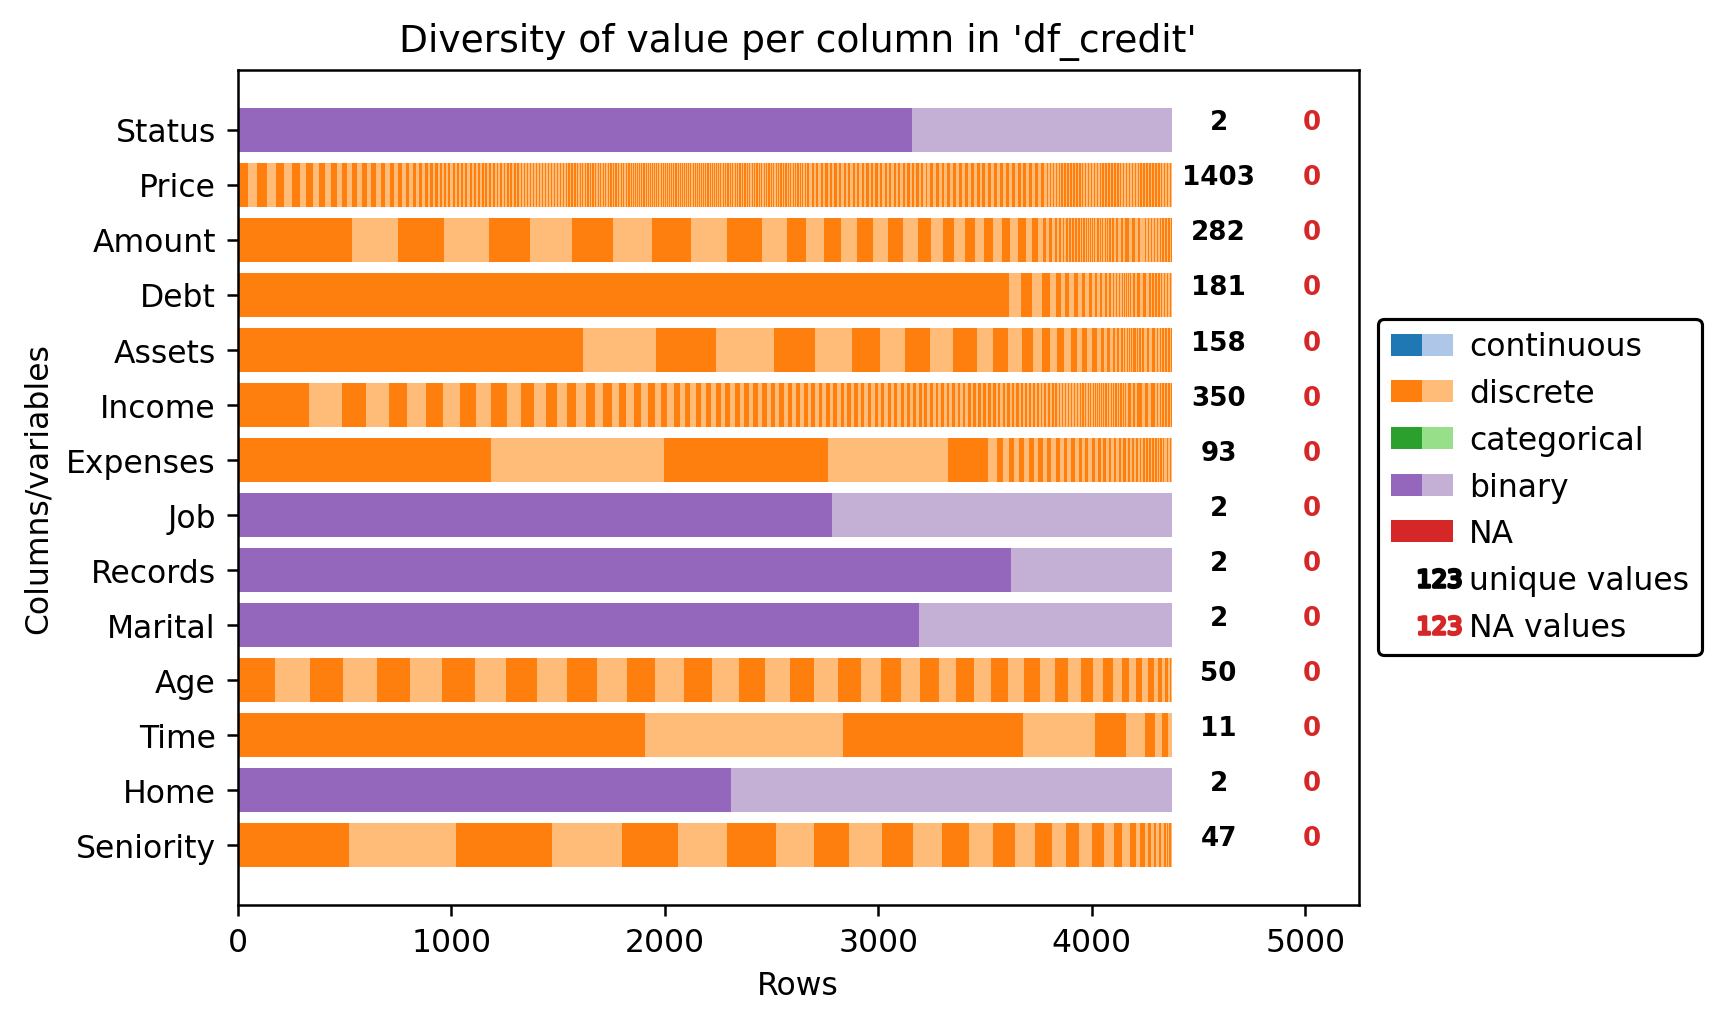

In [4]:
df_credit = pd.read_csv(CREDIT_SCORE, sep=";")

taa.explore_data(df_credit, "df_credit")

Le jeu de donnée 'credit_scoring.csv' présente 14 colonnes/variables et 4375 lignes/enregistrements. Chaque enregistrement est une demande de crédit, pour chaque demandeur est renseigné 13 variables d'entrée et 1 variable de sortie. Toutes les variables sont de natures numériques (certaines sont binaires). 
La colonne 'Status' est la variable de sortie que l'on va essayer de prédire à parir de ces variables d'entrée. Son codage correspond à:
- 1: Solvable
- 0: Non-solvable

In [5]:
from sklearn.model_selection import train_test_split


X, Y = df_credit.values[:, :-1], df_credit.values[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.5, random_state=1)

## Apprentissage et évaluation de modèles :

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

COLS_EVAL = ["method", "comment", "precision", "accuracy", "recall", "VP", "VN", "FP", "FN", "args"]
DATAS=(xtrain, ytrain, xtest, ytest)

# tests
cart_test = taa.test_model(*DATAS, DecisionTreeClassifier, random_state=1)
knn_test = taa.test_model(*DATAS, KNeighborsClassifier, n_neighbors=5)
mlp_test = taa.test_model(*DATAS, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1)

df_comparative = pd.concat([cart_test, knn_test, mlp_test], ignore_index=True)
df_comparative = df_comparative.drop_duplicates()

Confusion matrix with DecisionTreeClassifier  {'random_state': 1}

,predicted 0,predicted 1
is 0,325,279
is 1,318,1266


Confusion matrix with KNeighborsClassifier  {'n_neighbors': 5}

,predicted 0,predicted 1
is 0,189,415
is 1,187,1397


Confusion matrix with MLPClassifier  {'hidden_layer_sizes': (40, 20), 'random_state': 1}

,predicted 0,predicted 1
is 0,255,349
is 1,227,1357


,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}
2,MLPClassifier,,0.795428,0.736746,0.856692,1357,255,349,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}


On définit la **precision** (ou **positive predictive value**): $\frac{VP}{VP+FP}$ "Parmis les prédictions positives, lesquelles sont justes/vraies"

On définit l'**accuracy** : $\frac{VP+FN}{VP+FP+VN+FN}$ "Parmis l'ensemble des prédictions, lesquelles sont justes"

On définit le **recall** (ou **sensibilité** ou **true positive rate**): $\frac{VP}{VP+FN}$ "Parmis les cas postifs, lesquelles sont prédites"

Dans notre situation, nous représentons l'assureur, nous voulons éviter les impayés ! il faut alors minimiser au possible les **faux positifs** (c'est à dire ne pas attribuer un prêt alors qu'un agent ne l'aurait pas fait). 
Ainsi le critère de **précision** est plus important que le recall puisque son calcul prend en compte les faux positifs (la précision augment à mesure que les FP diminue).

Dans ce premier test, c'est la méthode par arbre de décision qui a la plus basse precision (0.82 c'est le plus prudent) mais au prix d'une nombre plus faible de call positif (et par conséquent moins de client).
Bien que toutes les méthodes ont une accuracy quasi-similaire, leurs décisions sont très différentes à en regarder les matrices de confusion associée.

## Normalisation des variables continues :

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standard scaling datas
stdScale=StandardScaler()
stdScale.fit(xtrain)
xtrain_ss, xtest_ss = stdScale.transform(xtrain), stdScale.transform(xtest)

# Min max scaling datas
mmScale= MinMaxScaler()
mmScale.fit(xtrain)
xtrain_mm, xtest_mm = mmScale.transform(xtrain), mmScale.transform(xtest)

DATAS_SS = (xtrain_ss, ytrain, xtest_ss, ytest)
DATAS_MM = (xtrain_mm, ytrain, xtest_mm, ytest)

# test
cart_test_ss = taa.test_model(*DATAS_SS, DecisionTreeClassifier, random_state=1, comment="StdScale")
cart_test_mm = taa.test_model(*DATAS_MM, DecisionTreeClassifier, random_state=1, comment="MinMaxScale")
knn_test_ss = taa.test_model(*DATAS_SS, KNeighborsClassifier, n_neighbors=5, comment="StdScale")
knn_test_mm = taa.test_model(*DATAS_MM, KNeighborsClassifier, n_neighbors=5, comment="MinMaxScale")
mlp_test_ss = taa.test_model(*DATAS_SS, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale")
mlp_test_mm = taa.test_model(*DATAS_MM, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="MinMaxScale")

df_comparative = pd.concat([df_comparative, cart_test_ss, cart_test_mm, knn_test_ss, knn_test_mm, mlp_test_ss, mlp_test_mm], ignore_index=True)
df_comparative = df_comparative.drop_duplicates()

Confusion matrix with DecisionTreeClassifier StdScale {'random_state': 1}

,predicted 0,predicted 1
is 0,322,282
is 1,315,1269


Confusion matrix with DecisionTreeClassifier MinMaxScale {'random_state': 1}

,predicted 0,predicted 1
is 0,325,279
is 1,315,1269


Confusion matrix with KNeighborsClassifier StdScale {'n_neighbors': 5}

,predicted 0,predicted 1
is 0,286,318
is 1,223,1361


Confusion matrix with KNeighborsClassifier MinMaxScale {'n_neighbors': 5}

,predicted 0,predicted 1
is 0,283,321
is 1,236,1348


Confusion matrix with MLPClassifier StdScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}

,predicted 0,predicted 1
is 0,342,262
is 1,227,1357


Confusion matrix with MLPClassifier MinMaxScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}

,predicted 0,predicted 1
is 0,321,283
is 1,179,1405


## Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales :

In [8]:
from sklearn.decomposition import PCA

# PCA computation
pca = PCA()
pca.fit(xtrain_ss)
pca_train, pca_test = pca.transform(xtrain_ss), pca.transform(xtest_ss)

# bind the 3 first PCA axis to std scalled x datas
xtrain_ss_pca = np.column_stack((xtrain_ss, pca_train[:, :3]))
xtest_ss_pca = np.column_stack((xtest_ss, pca_test[:, :3]))

DATAS_SS_PCA = (xtrain_ss_pca, ytrain, xtest_ss_pca, ytest)

# test
cart_test_ss_pca = taa.test_model(*DATAS_SS_PCA, DecisionTreeClassifier, random_state=1, comment="StdScale + PCA")
knn_test_ss_pca = taa.test_model(*DATAS_SS_PCA, KNeighborsClassifier, n_neighbors=5, comment="StdScale + PCA")
mlp_test_ss_pca = taa.test_model(*DATAS_SS_PCA, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale + PCA")

df_comparative = pd.concat([df_comparative, cart_test_ss_pca, knn_test_ss_pca, mlp_test_ss_pca], ignore_index=True)
df_comparative = df_comparative.drop_duplicates()

Confusion matrix with DecisionTreeClassifier StdScale + PCA {'random_state': 1}

,predicted 0,predicted 1
is 0,351,253
is 1,324,1260


Confusion matrix with KNeighborsClassifier StdScale + PCA {'n_neighbors': 5}

,predicted 0,predicted 1
is 0,283,321
is 1,212,1372


Confusion matrix with MLPClassifier StdScale + PCA {'hidden_layer_sizes': (40, 20), 'random_state': 1}

,predicted 0,predicted 1
is 0,318,286
is 1,217,1367


## Sélection de variables :

['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


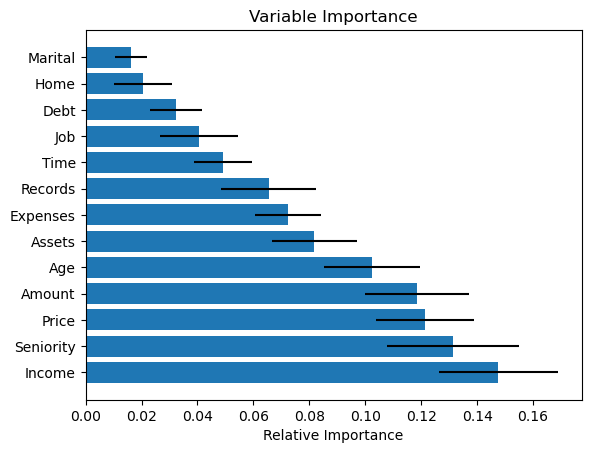

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state = 1)
clf.fit(xtrain_ss, ytrain)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features = df_credit.columns.values
print(features[sorted_idx])
padding = np.arange(xtrain_ss.size/len(xtrain_ss)) + 0.5 
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Relative Importance")
plt.title("Variable Importance") 
plt.show()

Saved to ./.cache_pickle/test_trimming/fc2a8a767dd744c6aad026a9afa8d1cd0daf727e.pkl


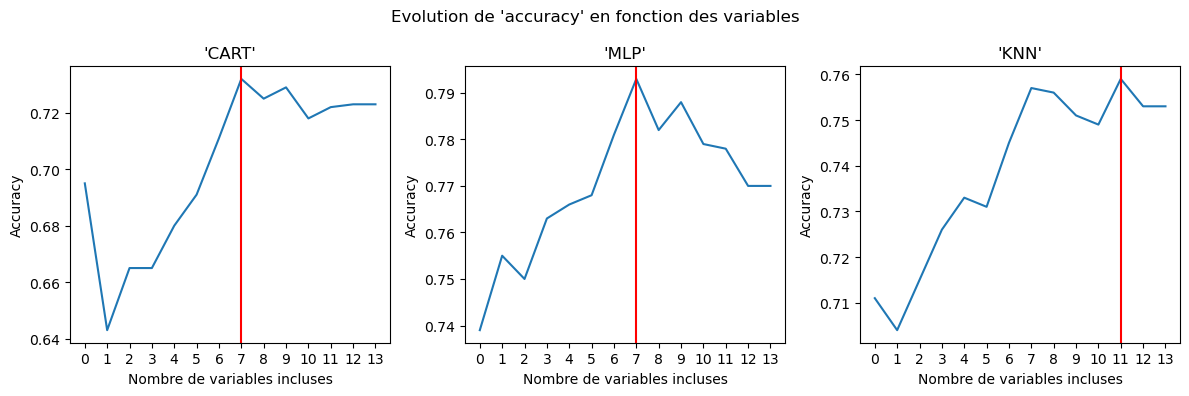

In [110]:
models = {
    "CART": DecisionTreeClassifier(random_state=1),
    "MLP" : MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1),
    "KNN" : KNeighborsClassifier(n_neighbors=5)
}

trim_test = taa.test_trimming(*DATAS_SS, models, sorted_idx)

taa.results_test_trimming(trim_test)

In [16]:
X_trimmed = X[:, sorted_idx[:8]]

xtrain_trim, xtest_trim, ytrain, ytest = train_test_split(X_trimmed, Y, test_size=0.5, random_state=1)

stdScale=StandardScaler()
stdScale.fit(xtrain_trim)

xtrain_trim_ss = stdScale.transform(xtrain_trim)
xtest_trim_ss = stdScale.transform(xtest_trim)

DATAS_TRIM_SS = (xtrain_trim_ss, ytrain, xtest_trim_ss, ytest)

cart_test_trim_ss = taa.test_model(*DATAS_TRIM_SS, DecisionTreeClassifier, random_state=1, comment="Trim + StdScale")
knn_test_trim_ss = taa.test_model(*DATAS_TRIM_SS, KNeighborsClassifier, n_neighbors=5, comment="Trim + StdScale")
mlp_test_trim_ss = taa.test_model(*DATAS_TRIM_SS, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="Trim + StdScale")

df_comparative = pd.concat([df_comparative, cart_test_trim_ss, knn_test_trim_ss, mlp_test_trim_ss], ignore_index=True)
df_comparative = df_comparative.drop_duplicates()
df_comparative.sort_values(by="precision")

Confusion matrix with DecisionTreeClassifier Trim + StdScale {'random_state': 1}

,predicted 0,predicted 1
is 0,328,276
is 1,310,1274


Confusion matrix with KNeighborsClassifier Trim + StdScale {'n_neighbors': 5}

,predicted 0,predicted 1
is 0,290,314
is 1,218,1366


Confusion matrix with MLPClassifier Trim + StdScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}

,predicted 0,predicted 1
is 0,340,264
is 1,189,1395


,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}
2,MLPClassifier,,0.795428,0.736746,0.856692,1357,255,349,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
6,KNeighborsClassifier,MinMaxScale,0.807669,0.745430,0.851010,1348,283,321,236,{'n_neighbors': 5}
10,KNeighborsClassifier,StdScale + PCA,0.810396,0.756399,0.866162,1372,283,321,212,{'n_neighbors': 5}
5,KNeighborsClassifier,StdScale,0.810602,0.752742,0.859217,1361,286,318,223,{'n_neighbors': 5}
13,KNeighborsClassifier,Trim + StdScale,0.813095,0.756856,0.862374,1366,290,314,218,{'n_neighbors': 5}
3,DecisionTreeClassifier,StdScale,0.818182,0.727148,0.801136,1269,322,282,315,{'random_state': 1}
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
4,DecisionTreeClassifier,MinMaxScale,0.819767,0.728519,0.801136,1269,325,279,315,{'random_state': 1}
12,DecisionTreeClassifier,Trim + StdScale,0.821935,0.732176,0.804293,1274,328,276,310,{'random_state': 1}


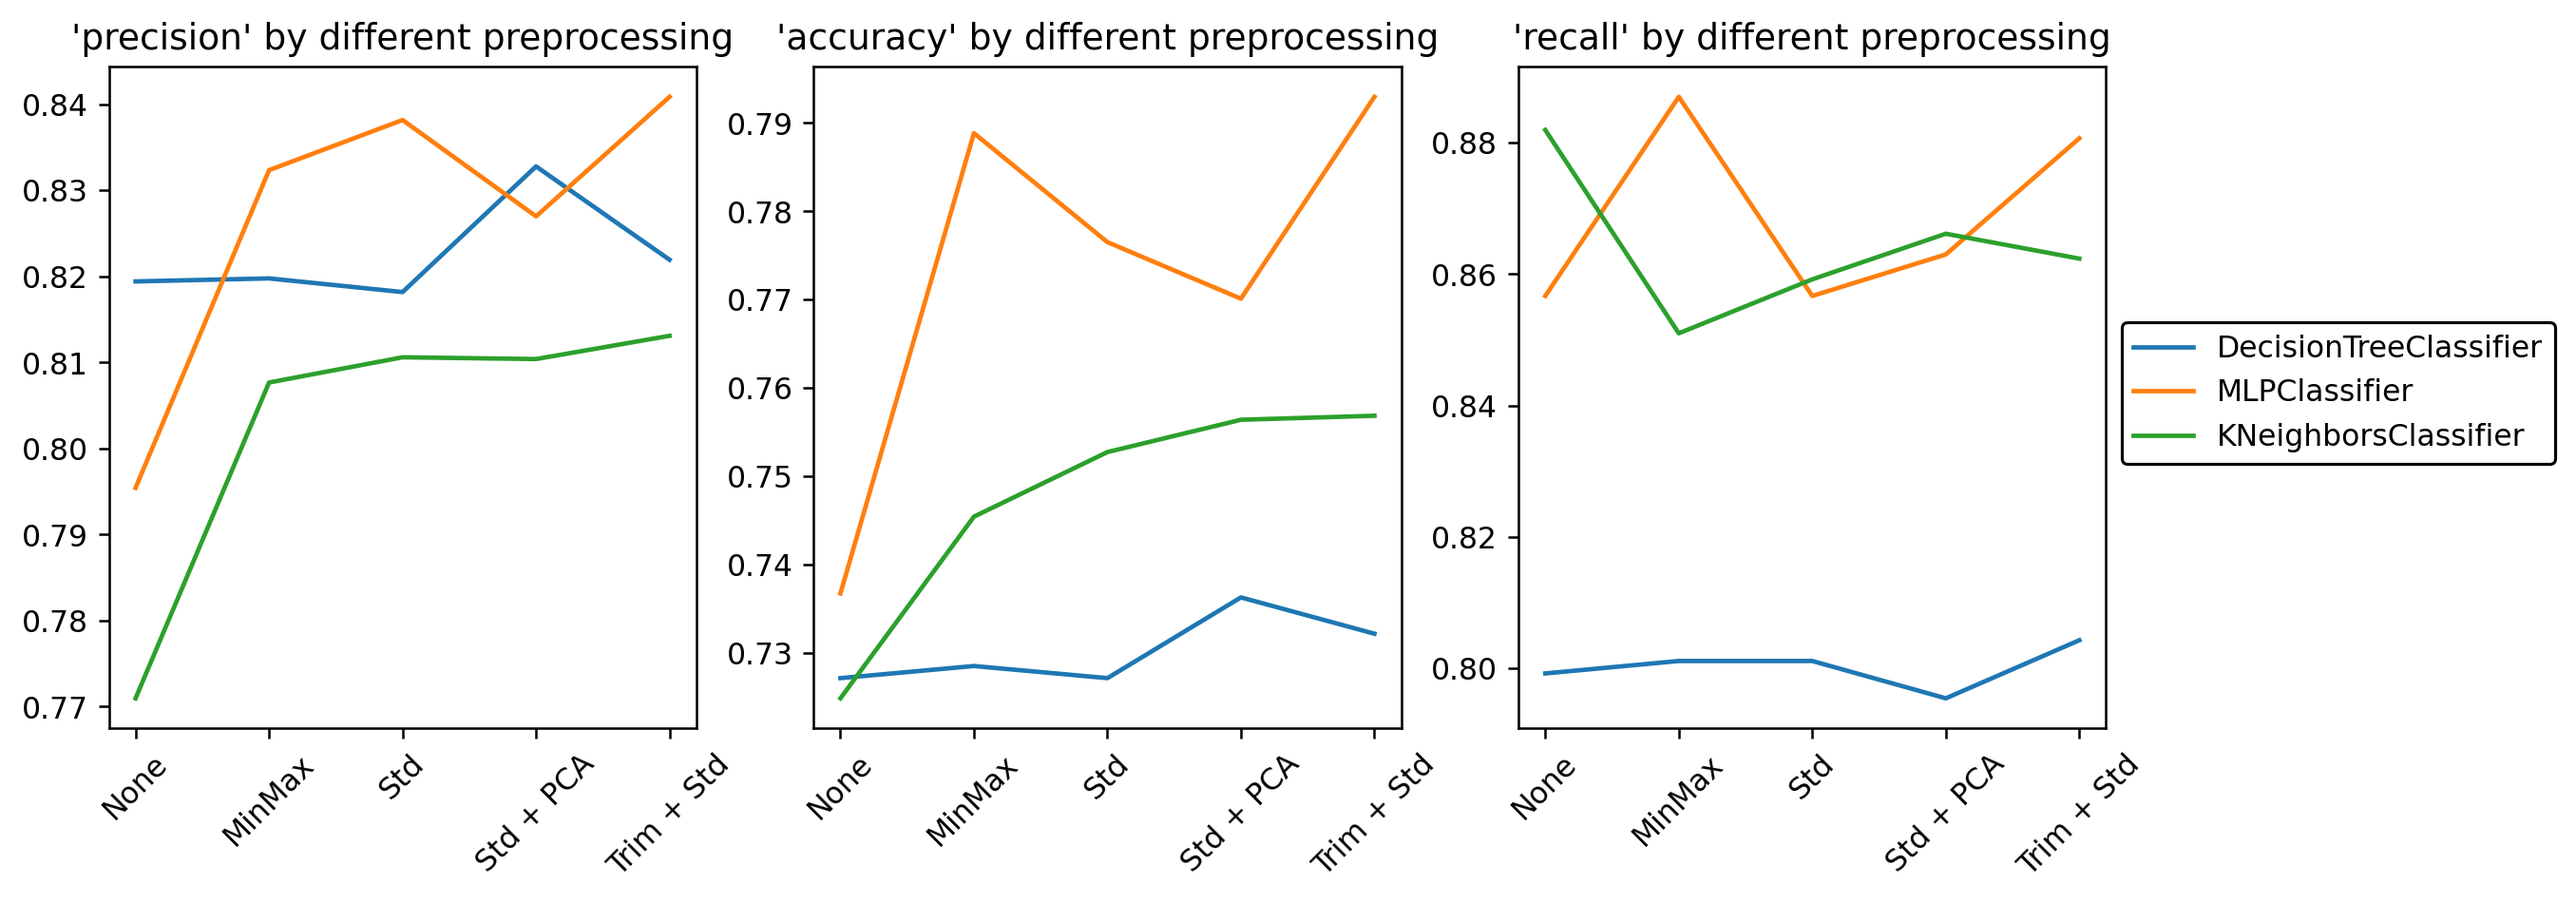

In [17]:
taa.comparative_preprocessing(df_comparative)

## Paramétrage des classifieurs :

In [15]:
# KNN test
parameters_knn = {
    "n_neighbors" : [i for i in range(1, 100, 5)],
    "weights" : ["uniform", "distance"],
    "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
gs_KNN = taa.find_best_param(KNeighborsClassifier, parameters_knn, xtrain_trim_ss, ytrain)

# CART test
parameters_cart = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "splitter" : ["best", "random"],
    "max_depth" : [i for i in range(1, 16)],
    "min_samples_leaf" : [i for i in range(1, 16)],
    "min_samples_split" : [i for i in range(1, 16)]
}
gs_CART = taa.find_best_param(DecisionTreeClassifier, parameters_cart, xtrain_trim_ss, ytrain)

# MLP test
parameters_mlp = {
    "activation" : ["identity", "logistic", "tanh", "relu"],
    "hidden_layer_sizes" : [(l1, l2) for l1 in range(10, 121, 10) for l2 in range(10, 81, 10)]
}
gs_MLP = taa.find_best_param(MLPClassifier, parameters_mlp, xtrain_trim_ss, ytrain)

Best params for 'KNeighborsClassifier' is :
{'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}
score (precision): 0.810517460555068


Saved to ./.cache_pickle/find_best_param/6aeed71825438416454318e0db788aec8e1f3041.pkl


KeyboardInterrupt: 

## Création d'un pipeline :

In [ ]:
from pickle import load, dump

SIGNIFICANCE_COLS = sorted_idx[:8]

pipe_KNN = taa.make_pipeline(xtrain, ytrain, KNeighborsClassifier, SIGNIFICANCE_COLS, gs_KNN.best_params_)
pipe_CART = taa.make_pipeline(xtrain, ytrain, DecisionTreeClassifier, SIGNIFICANCE_COLS, gs_CART.best_params_)
pipe_MLP = taa.make_pipeline(xtrain, ytrain, MLPClassifier, SIGNIFICANCE_COLS, gs_MLP.best_params_)

dump(pipe_KNN, open("../res/pipe_knn.pkl", "wb"))
dump(pipe_CART, open("../res/pipe_cart.pkl", "wb"))
dump(pipe_MLP, open("../res/pipe_mlp.pkl", "wb"))

del pipe_KNN, pipe_CART, pipe_MLP

pipe_KNN = load(open("../res/pipe_knn.pkl", "rb"))
pipe_CART = load(open("../res/pipe_cart.pkl", "rb"))
pipe_MLP = load(open("../res/pipe_mlp.pkl", "rb"))

display(pipe_KNN)
display(pipe_CART)
display(pipe_MLP)

test_pipe = taa.test_pipeline([pipe_KNN, pipe_CART, pipe_MLP], xtest, ytest)
display(test_pipe)

Saved to ./.cache/make_pipeline/f26b824421a965f0c3ea56524ee5c8639ace389e.pkl


NameError: name 'gs_cart' is not defined

Pour utiliser une version 'pickle' d'un modèle:

```python
import pickle

mon_modele = pickle.load(open("<path_du_modele>", "rb"))

Y_predit = mon_model.predict(X_data)
# nul besoin que X_data soit scale ou trim, le pipeline le fait déjà
```

## Comparaisons de plusieurs algorithmes d'apprentissages :

In [18]:
from IPython.display import Markdown

txt = "|**Key**|**Classifiers**|\n|--|--|\n"
for k, v in taa.CLASSIFIERS.items():
    txt += f"|{k}|{v}|\n"

Markdown(txt)

|**Key**|**Classifiers**|
|--|--|
|RF_10|RandomForestClassifier(n_estimators=10, random_state=1)|
|RF_20|RandomForestClassifier(n_estimators=20, random_state=1)|
|RF_40|RandomForestClassifier(n_estimators=40, random_state=1)|
|RF_80|RandomForestClassifier(n_estimators=80, random_state=1)|
|RF_120|RandomForestClassifier(n_estimators=120, random_state=1)|
|RF_160|RandomForestClassifier(n_estimators=160, random_state=1)|
|NB|GaussianNB()|
|QDA|QuadraticDiscriminantAnalysis()|
|MLP_20_10|MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1)|
|MLP_40_20|MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)|
|MLP_60_30|MLPClassifier(hidden_layer_sizes=(60, 30), random_state=1)|
|MLP_100_50|MLPClassifier(hidden_layer_sizes=(100, 50), random_state=1)|
|CART_gini|DecisionTreeClassifier(random_state=1)|
|CART_entropy|DecisionTreeClassifier(criterion='entropy', random_state=1)|
|CART_log_loss|DecisionTreeClassifier(criterion='log_loss', random_state=1)|
|KNN_10|KNeighborsClassifier(n_neighbors=10)|
|KNN_20|KNeighborsClassifier(n_neighbors=20)|
|KNN_40|KNeighborsClassifier(n_neighbors=40)|
|KNN_80|KNeighborsClassifier(n_neighbors=80)|
|KNN_120|KNeighborsClassifier(n_neighbors=120)|
|KNN_160|KNeighborsClassifier(n_neighbors=160)|
|Bag_10|BaggingClassifier(random_state=1)|
|Bag_20|BaggingClassifier(n_estimators=20, random_state=1)|
|Bag_40|BaggingClassifier(n_estimators=40, random_state=1)|
|Bag_80|BaggingClassifier(n_estimators=80, random_state=1)|
|Bag_120|BaggingClassifier(n_estimators=120, random_state=1)|
|Bag_160|BaggingClassifier(n_estimators=160, random_state=1)|
|AdaB_20|AdaBoostClassifier(n_estimators=20, random_state=1)|
|AdaB_40|AdaBoostClassifier(n_estimators=40, random_state=1)|
|AdaB_80|AdaBoostClassifier(n_estimators=80, random_state=1)|
|AdaB_120|AdaBoostClassifier(n_estimators=120, random_state=1)|
|AdaB_160|AdaBoostClassifier(n_estimators=160, random_state=1)|


Loaded from ./.cache_pickle/run_classifiers/bfb068e3e667325ab93451cec810bf6a0d131099.pkl


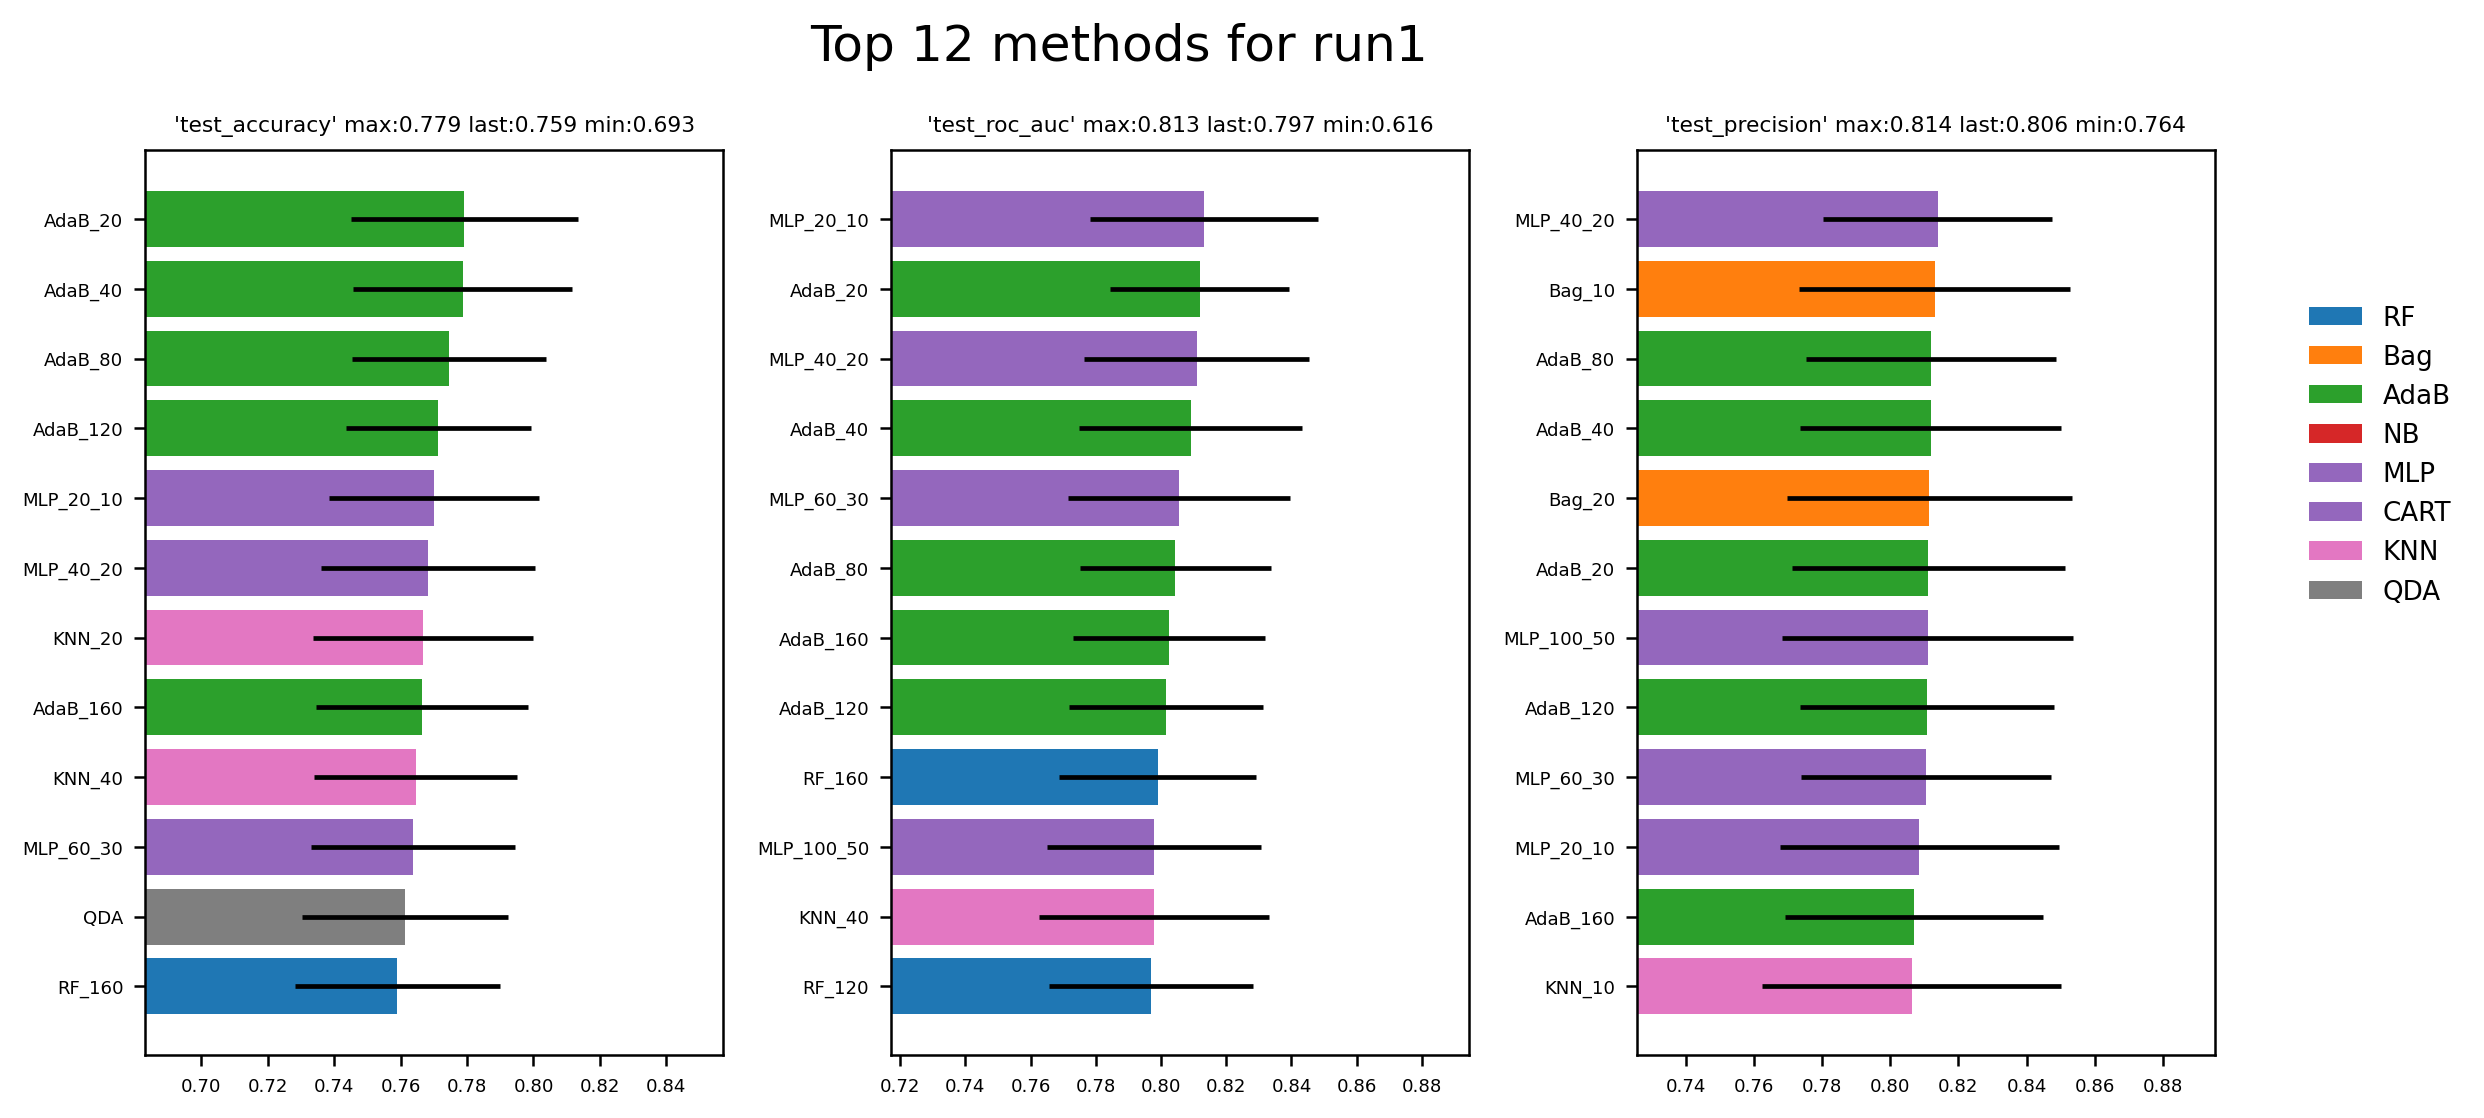

In [118]:
run1=taa.run_classifiers(taa.CLASSIFIERS, xtrain_trim_ss, ytrain)
taa.results_run_clfs(run1, "run1", top=12)

# Apprentissage supervisé : Données hétérogènes

## Chargement des données et préparation

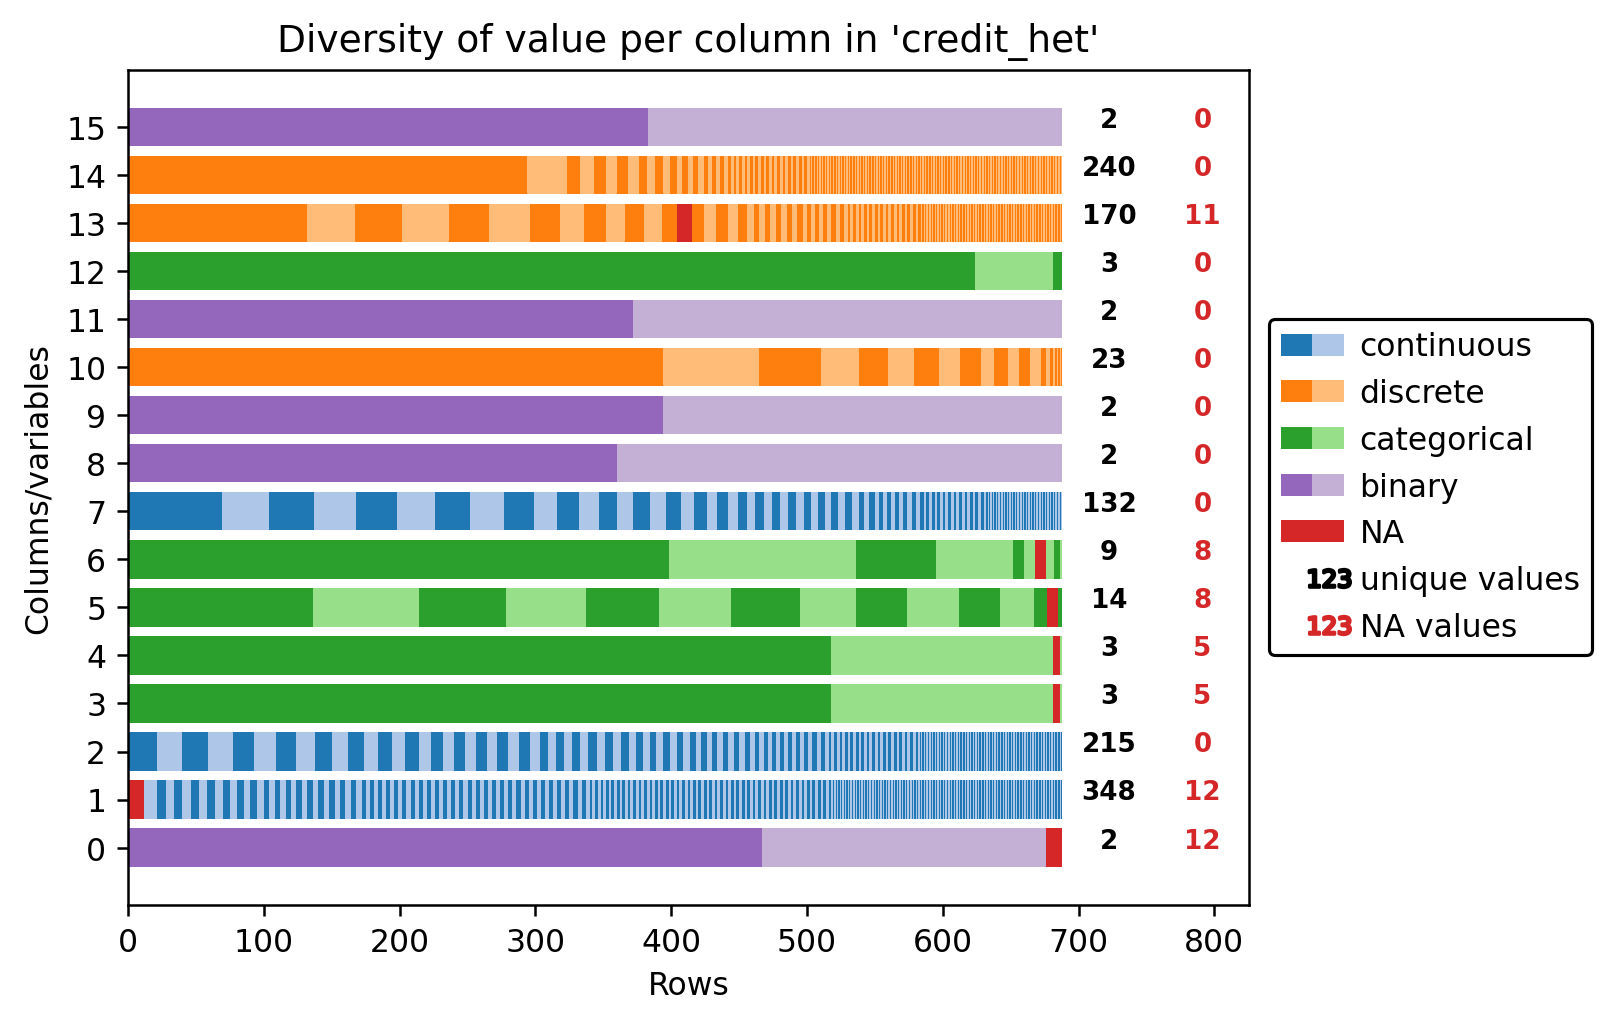

In [121]:
df_credit_het = pd.read_csv(CREDIT_SCORE_HET, sep="\t", header=None, na_values="?")

taa.explore_data(df_credit_het, "def_credit_het")

In [151]:
CAT_COLS = [0, 3, 4, 5, 6, 8, 9, 11, 12]
NUM_COLS = [1, 2, 7, 10, 13, 14]

# to numpy array
X, Y = df_credit_het.values[:, :15], df_credit_het.values[:, 15]

# separate into X_num, X_cat and Y arrays
X_num = X[:, NUM_COLS]
X_num = X_num.astype(np.float64)

X_cat = X[:, CAT_COLS]

Y[Y == "+"] = 1
Y[Y == "-"] = 0
Y = Y.astype(np.float64)

# withour NA
without_na = ~np.isnan(X_num).any(axis=1)
X_num_nona = X_num[without_na]
Y_nona = Y[without_na]

## 2) Normalisation des variables continues :

Par continues on entend toute valeurs numériques trouvées dans le jeu de donnée.

In [141]:
# Standard scaling X_num
stdScale=StandardScaler()
X_num_nona_ss = stdScale.fit_transform(X_num_nona)

# Min max scaling X_num
mmScale= MinMaxScaler()
X_num_nona_mm = mmScale.fit_transform(X_num_nona)

# run
run2_vanilla = taa.run_classifiers(taa.CLASSIFIERS, X_num_nona, Y_nona)
run2_ss = taa.run_classifiers(taa.CLASSIFIERS, X_num_nona_ss, Y_nona)
run2_mm = taa.run_classifiers(taa.CLASSIFIERS, X_num_nona_mm, Y_nona)

taa.results_run_clfs(run2_vanilla, "run2_vanilla")
taa.results_run_clfs(run2_ss, "run2_ss")
taa.results_run_clfs(run2_mm, "run2_mm")

Loaded from ./.cache_pickle/run_classifiers/d8e29879db9017095522f3cb7328e7d71f687429.pkl
(1/32): RF_10 is running! 	DONE
(2/32): RF_20 is running! 	DONE
(3/32): RF_40 is running! 	DONE
(4/32): RF_80 is running! 	DONE
(5/32): RF_120 is running! 	DONE
(6/32): RF_160 is running! 	DONE
(7/32): NB is running! 	DONE
(8/32): QDA is running! 	DONE
(9/32): MLP_20_10 is running! 	DONE
(10/32): MLP_40_20 is running! 	DONE
(11/32): MLP_60_30 is running! 	DONE
(12/32): MLP_100_50 is running! 	DONE
(13/32): CART_gini is running! 	DONE
(14/32): CART_entropy is running! 	DONE
(15/32): CART_log_loss is running! 	DONE
(16/32): KNN_10 is running! 	DONE
(17/32): KNN_20 is running! 	DONE
(18/32): KNN_40 is running! 	DONE
(19/32): KNN_80 is running! 	DONE
(20/32): KNN_120 is running! 	DONE
(21/32): KNN_160 is running! 	DONE
(22/32): Bag_10 is running! 	DONE
(23/32): Bag_20 is running! 	DONE
(24/32): Bag_40 is running! 	DONE
(25/32): Bag_80 is running! 	DONE
(26/32): Bag_120 is running! 	DONE
(27/32): Bag_16

## Traitement de données manquantes : 

In [152]:
from sklearn.impute import SimpleImputer

# for categorical data
X_cat_imp = np.copy(X_cat)
X_cat_imp[pd.isna(X_cat_imp)] = "NA"
for i in range(len(CAT_COLS)):
    unique_val, val_idx = np.unique(X_cat_imp[:, i], return_inverse=True) 
    X_cat_imp[:, i] = val_idx

imp_cat = SimpleImputer(missing_values=0, strategy='most_frequent') 
X_cat_imp[:, range(5)] = imp_cat.fit_transform(X_cat_imp[:, range(5)])

#  for numerical data
X_num_imp = np.copy(X_num)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean') 
X_num_imp = imp_num.fit_transform(X_num_imp)

## Traitement de variables catégorielles :

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_cat_imp_bin = OneHotEncoder().fit_transform(X_cat_imp).toarray()

# Standard scaling X_num_imp
stdScale=StandardScaler()
X_num_imp_ss = stdScale.fit_transform(X_num_imp)

# Min max scaling X_num_imp
mmScale= MinMaxScaler()
X_num_imp_mm = mmScale.fit_transform(X_num_imp)

# bind X_cat_imp_binary with X_num_imp
X_combined = np.concatenate((X_num_imp, X_cat_imp_bin), axis=1)
X_combined_mm = np.concatenate((X_num_imp_ss, X_cat_imp_bin), axis=1)
X_combined_ss = np.concatenate((X_num_imp_mm, X_cat_imp_bin), axis=1)

# run
run3_vanilla = taa.run_classifiers(CLASSIFIERS, X_combined, Y)
run3_ss = taa.run_classifiers(CLASSIFIERS, X_combined_mm, Y)
run3_mm = taa.run_classifiers(CLASSIFIERS, X_combined_ss, Y)

taa.results_run_clfs(run3_vanilla, "run3_imp_vanilla")
taa.results_run_clfs(run3_ss, "run2_imp_ss")
taa.results_run_clfs(run3_mm, "run2_imp_mm")

# Apprentissage supervisé sur des données textuelles : Feature engineering et Classification 

## Lecture et préparation des données:

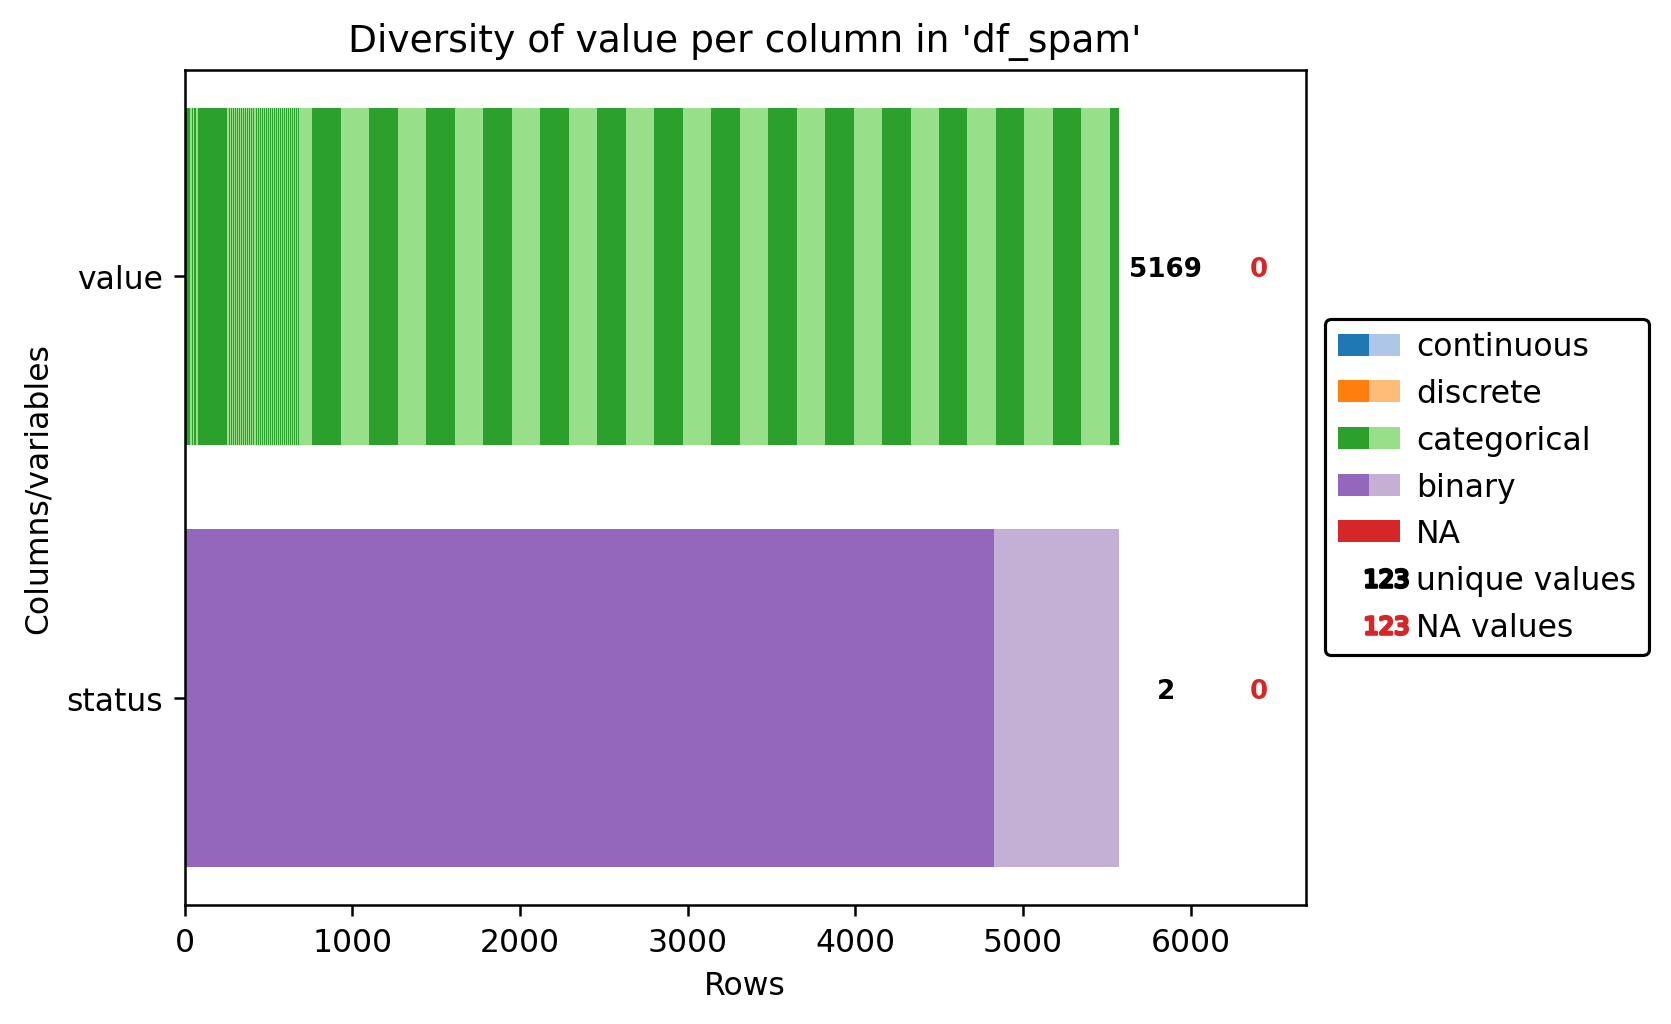

In [170]:
df_spam = pd.read_csv(SPAM, sep = "\t", header = None)
df_spam = df_spam.rename(columns = {0 : "status", 1 : "value"})

taa.explore_data(df_spam, "df_spam")

In [171]:
Y = df_spam["status"].values
X = df_spam["value"].values
Y[Y == "spam"] = 1
Y[Y == "ham"] = 0
Y = Y.astype(np.int64)

## CountVectorizer :

In [178]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', min_df = 10)
X_vec = vectorizer.fit_transform(X)
X_vec = X_vec.toarray()

run4 = taa.run_classifiers(taa.CLASSIFIERS, X_vec, Y)
taa.results_run_clfs(run4, "run4")

(1/35): RF_10 is running!...   DONE
(2/35): RF_20 is running!...   DONE
(3/35): RF_40 is running!...   DONE
(4/35): RF_80 is running!

KeyboardInterrupt: 

## Tf–idf term weighting : 

In [179]:
from sklearn.feature_extraction.text import TfidfTransformer

tfid = TfidfTransformer(smooth_idf=False)
X_vec_tfid = tfid.fit_transform(X_vec)
X_vec_tfid = X_vec_tfid.toarray()

run4_tfid = taa.run_classifiers(taa.CLASSIFIERS, X_vec_tfid, Y)
taa.results_run_clfs(run4_tfid, "run4_tfid")

(1/35): RF_10 is running!...   DONE
(2/35): RF_20 is running!...   DONE
(3/35): RF_40 is running!...   DONE
(4/35): RF_80 is running!...   DONE
(5/35): RF_120 is running!

KeyboardInterrupt: 

## TruncatedSVD :

In [183]:
from sklearn.decomposition import TruncatedSVD

# 100 concepts
svd100 = TruncatedSVD(n_components=100, n_iter=20, random_state=1)
X_vec_tfid_svd100 = svd100.fit_transform(X_vec_tfid)

run4_tfid_svd100 = taa.run_classifiers(taa.CLASSIFIERS, X_vec_tfid_svd100, Y)
taa.results_run_clfs(run4_tfid_svd100, "run4_tfid_svd100")

## Pipeline :

In [192]:
from sklearn.pipeline import Pipeline

text_mining_RF = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', min_df = 10)), 
    ("tfid", TfidfTransformer(smooth_idf=False)), 
    ("svd", TruncatedSVD(n_components=10, random_state=1)),
    ('model', RandomForestClassifier(n_estimators=120, random_state=1))
])

text_mining_MLP = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', min_df = 10)),
    ("tfid", TfidfTransformer(smooth_idf=False)), 
    ("truncatedSVD", TruncatedSVD(n_components=10, random_state=1)),
    ('model', MLPClassifier(hidden_layer_sizes=(60, 30), random_state=1))
])

## Application sur un autre jeu de données :

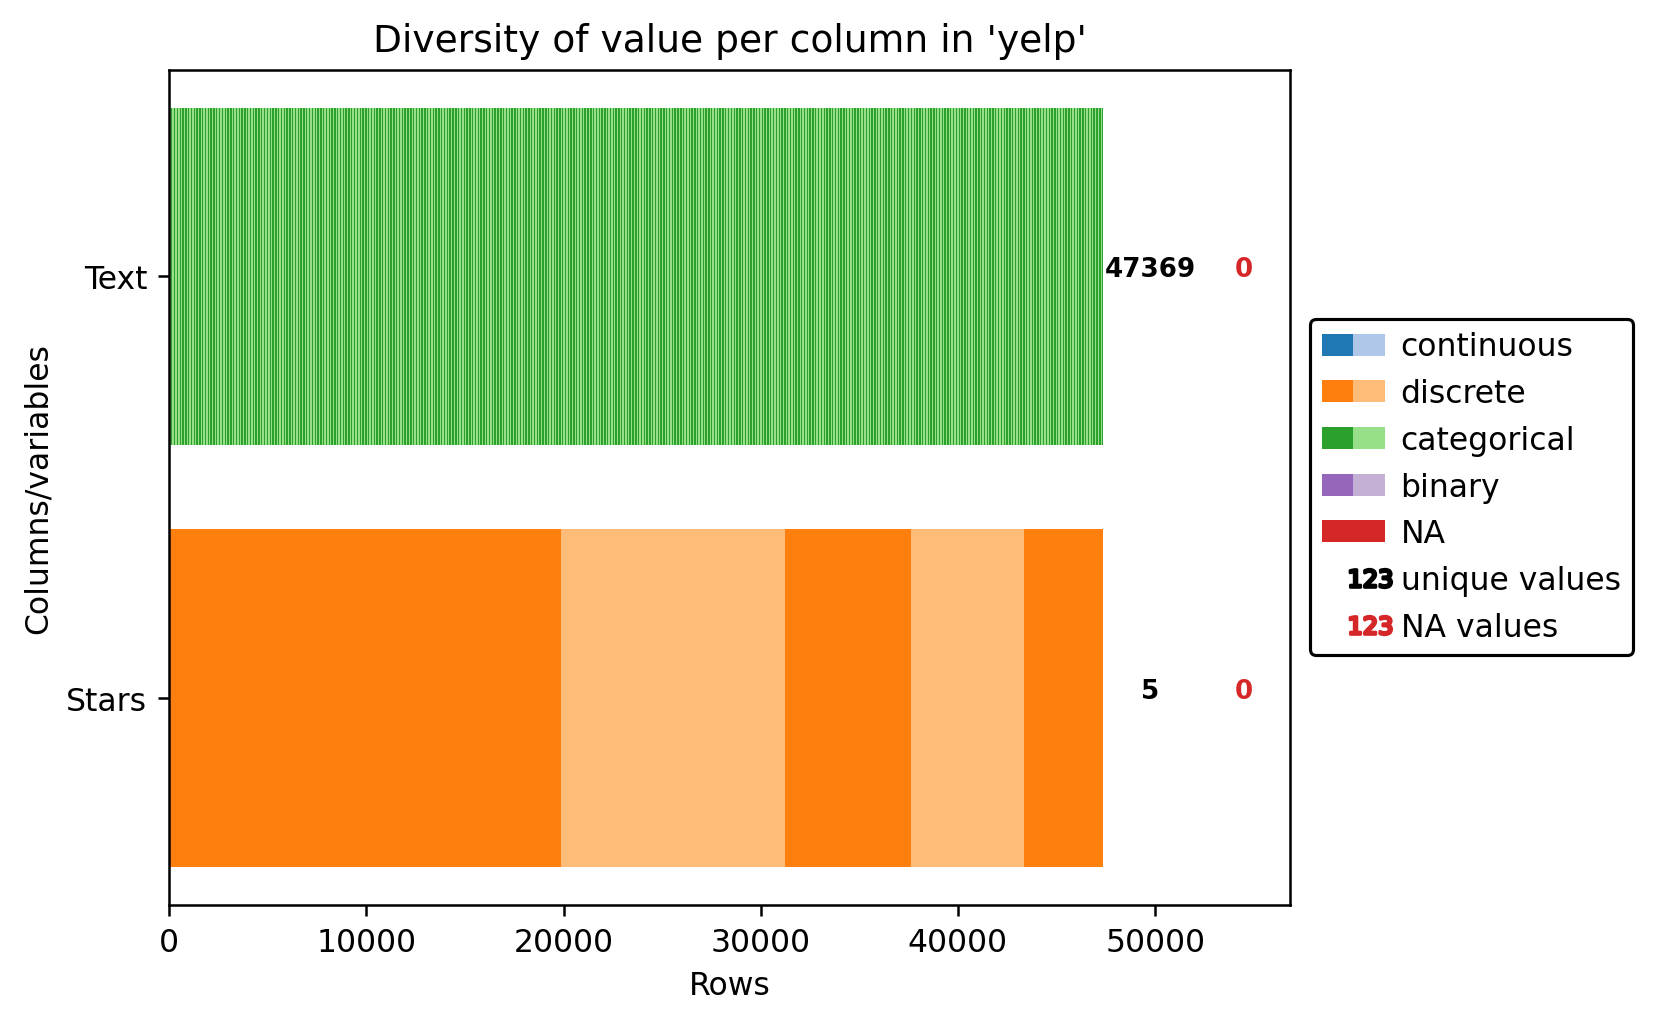

In [189]:
df_yelp = pd.read_csv(YELP, header = 0, sep = ';', encoding='iso-8859-1')

taa.explore_data(df_yelp, "df_yelp")

In [194]:
X = df_yelp["Text"].values
Y = df_yelp["Stars"].values

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.5, random_state=1)

text_mining_RF.fit(xtrain, ytrain)
text_mining_MLP.fit(xtrain, ytrain)

ypred_RF = text_mining_RF.predict(xtest)
ypred_MLP = text_mining_MLP.predict(xtest)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=10, stop_words='english')),
                ('tfid', TfidfTransformer(smooth_idf=False)),
                ('truncatedSVD', TruncatedSVD(n_components=10, random_state=1)),
                ('model',
                 MLPClassifier(hidden_layer_sizes=(60, 30), random_state=1))])

In [195]:
from importlib import reload
import lib.taa_tools as taa
reload(taa)

<module 'lib.taa_tools' from '/Users/thomas/Cours/master/s3/TAA/tp_taa_apprentissage_supervisee/source/lib/taa_tools.py'>